**Table of contents**<a id='toc0_'></a>    
1. [Business Understanding](#toc1_)    
2. [Data Understanding](#toc2_)      
3. [Load Data:](#toc3_)    
4. [Data Cleaning:](#toc4_)    
5. [NLP Data Pre-Processing:](#toc5_)    
6. [Exploratory Data Analysis](#toc6_)    
7. [Train test split and evaluation metrics](#toc7_)    
8. [DummyModel](#toc8_)    
9. [Logistic regression](#toc9_)    
10. [MultinomialNB Model](#toc10_)    
11. [Random Forest Model](#toc11_)    
12. [XGBoosting](#toc12_)    
13. [Embedding](#toc13_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
#"""
#If Using Google Colab:
from google.colab import drive
drive.mount('/content/drive')
#"""

Mounted at /content/drive


# <a id='toc1_'></a>[<span style="color:blue">Business Understanding</span>](#toc0_)
We are the data science team for an investment consulting company. Our problem is that we want to make use of social media data to inform investing advice based on predicting sentiment of text that includes a given brand's name and/or products. Our first foray into this work is to build a model that predicts the sentimet of tweets on Twitter/ X, using the categories positive, negative or neutral. Our predictors include a brand-name (Apple or Google) and product name (Android, iPhone, etc). Our goal is to develop a high-accuracy model to gauge brand satisfaction. We'll use the sentiment of the tweet to compare the proportion of positive reviews associated with Apple products versus Google products. The creation of this model can then be generalized by training it on a wider range of data from social media in order to gauge brand satisfaction segmented by attributes such as event hashtags, top brand influencers or how sentiment for a given brand, product, or product model has evolved over time.

# <a id='toc2_'></a>[<span style="color:blue">Data Understanding</span>](#toc0_)
* The subject of our Twitter/ X data centers on the 2013 SXSW conference [here](https://schedule.sxsw.com/2013/events/grid?day=8)
  * South by Southwest (SXSW) is a multi-conference event of interactive media, music and film that occurs in Austin, Texas each year in March. Each tweet in our data mentions either Apple products, Google products, or both as well as specific products under those brands.
* We sourced our data from data.world which can be found [here](https://data.world/crowdflower/brands-and-product-emotions)

### <a id='toc2_1_1_'></a>[<span style='color:blue'>Number of Instances</span>:](#toc0_)
- `9,093`


### <a id='toc2_1_2_'></a>[<span style="color:blue">Features</span>:](#toc0_)
* **`tweet_text`**
  * Text string of entire tweet
* **`emotion_in_tweet_is_directed_at`**
  * Product and/or Brand mentioned in tweet
  * Some NULL values here -- either none listed in this field, and/or missing from `tweet_text`
* **`is_there_an_emotion_directed_at_a_brand_or_product`**
  * This is our predictor value
  * Values for sentiment of tweet:
    * `Positive Emotion`
    * `Negative Emotion`
    * `No emotion toward brand or product`
    * `I can't tell`

#### <a id='toc2_1_2_1_'></a>[<span style="color:blue">Apple Products mentioned in tweet text</span>](#toc0_)
* `apple`                             
* `ipad`                               
* `iPad`
* `iphone`                            
* `Apple`
* `iPad or iPhone App`
* `iPhone`
* `Other Apple product or service`

#### <a id='toc2_1_2_2_'></a>[<span style="color:blue">Google Products mentioned in tweet text</span>](#toc0_)
* `Google`                             
* `android`                            
* `google`                              
* `Other Google product or service`    
* `Android App`                        
* `Android`

### <a id='toc2_1_3_'></a>[Install additional libraries if needed:](#toc0_)

In [2]:
#"""
!pip install wordcloud
!pip install keras-tuner
!pip install tensorflow
#"""

# Check sklearn version:
"""
import sklearn
sklearn.__version__
"""

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.2 MB/s eta 0:00:00


'\nimport sklearn\nsklearn.__version__\n'

In [3]:
### Prior to code execution, automatically reloads modules.
%load_ext autoreload
%autoreload 2

### Core Data Science Packages:
import numpy as np
import pandas as pd

### Operating System Interaction:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

### Data Handling:
import unicodedata
import string
import re
# For non-existant key, returns default value
from collections import defaultdict

### Natural Language Processing:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk.collocations as collocations
from nltk.util import ngrams
# NLTK word corpus lists:
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

### Scikit-learn Models:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from xgboost import XGBClassifier

### Data Preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
import joblib
import pickle

### Model Validation:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay, log_loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold

### Model Tuning:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Keras and Tensorflow:
import keras
from keras import layers
from kerastuner.tuners import RandomSearch
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import datasets, layers, models, callbacks

### Data Visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### Suppress Warnings:
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend


<ipython-input-3-158aeec90334>:71: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# <a id='toc3_'></a>[Load Data:](#toc0_)

In [4]:
### For Loading Data into Google Colab from Google Drive:

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/raw_data/judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')

In [5]:
# data = pd.read_csv("./raw_data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

# <a id='toc4_'></a>[Data Cleaning:](#toc0_)

### <a id='toc4_1_1_'></a>[Preview Data:](#toc0_)
- Preliminary observations:
  - Row #6 is missing the text of the tweet, so we can drop this row.
  - A tweet can mention multiple products
  - Some rows have a missing value in `emotion_in_tweet_is_directed_at` -- yet do mention a product in text of tweet. These missing values could be filled using string matching.
  - Unimportant words:
    - There are special characters, hyperlinks, and redundant sequences of characters such as #SXSW and mentions prefixed by `@` which may be beneficial to remove as they do not add to signal for predicting sentiment.

In [6]:
# Preview Data:
data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


### <a id='toc4_1_2_'></a>[Drop row #6 above where `tweet_text` = `NaN`](#toc0_)

In [7]:
# Check that there's only one row where tweet_text is missing:
data.tweet_text.isna().sum()

1

In [8]:
# Drop that row:
data.dropna(subset=['tweet_text'], inplace=True)

### <a id='toc4_1_3_'></a>[Drop Duplicate Rows (duplicate `tweet_text`):](#toc0_)
- We observed below that there are 9,092 total rows, and only 9,065 *unique* values for `tweet_text` - thus there are duplicates we need to drop

In [9]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9092
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5388


In [10]:
# Drop where tweet_text is duplicated:
data.drop_duplicates(subset=['tweet_text'], inplace=True)

In [11]:
# Check .describe() again:
# We now have the same number of instances as unique values
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9065,3280,9065
unique,9065,9,4
top,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPad,No emotion toward brand or product
freq,1,943,5372


### <a id='toc4_1_4_'></a>[Rename columns for readability:](#toc0_)
- `emotion_in_tweet_is_directed_at`
  - New Column Name = `brand`
- `is_there_an_emotion_directed_at_a_brand_or_product`
  - New Column Name = `sentiment`

In [12]:
data.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [13]:
# Preview new column names:
data.head()

,tweet_text,brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [14]:
# Drop that row:
data.dropna(subset=['tweet_text'], inplace=True)

### <a id='toc4_1_5_'></a>[ columns for categorical variables:](#toc0_)
- Because the `brand` column is missing values in some instances (NaN when in fact `iPhone` exists in the `tweet_text` for example), we'll create a column for each product and brand, based on searching `tweet_text` for these strings: "Apple", "Google", "iPad", "iPhone", "Android", "goog"
- Then, we'll search those columns and return "Apple" or "Google" depending on matches with individual keyword columns.

##### <a id='toc4_1_5_1_1_'></a>[Columns for each keyword, where value = keyword](#toc0_)
- Keywords are a list of product and brand words we found in `tweet_text`:
  - Apple
  - Google
  - iPad
  - iPhone
  - Android
  - goog

In [15]:
# Define Keywords list
keywords = ["Apple", "Google", "iPad", "iPhone", "Android", "goog"]

# Create a new column for each keyword, where value = keyword if found in tweet_text
for keyword in keywords:
    data[keyword] = data['tweet_text'].str.extract(f'({keyword})', flags=re.IGNORECASE)

In [16]:
# Preview new keyword columns:
data.head()

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android,goog
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NaN,NaN,NaN,iPhone,NaN,NaN
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,NaN,NaN,iPad,iPhone,NaN,NaN
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,NaN,NaN,iPad,NaN,NaN,NaN
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,NaN,NaN,NaN,iPhone,NaN,NaN
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,NaN,Google,NaN,NaN,NaN,Goog


#### <a id='toc4_1_5_2_'></a>[Create `Product` column](#toc0_)
- In the case of a tweet mentioning both Apple and Google products, we defaulted to Apple as a heuristic method - we don't believe this skewed the representation of brands in a significant way.

In [17]:
# Create product column with values "Apple" or "Google" by grouping which keywords belong to a given brand:
data['product'] = data[['Apple', 'iPhone', 'iPad', 'Google', 'Android']].apply(lambda x: 'Apple' if x[['Apple', 'iPhone', 'iPad']].any()
                                                                                else 'Google' if x[['Google', 'Android']].any()
                                                                                else None, axis=1)

In [18]:
# Preview new Product Created from keyword columns:
data.head()

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android,goog,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NaN,NaN,NaN,iPhone,NaN,NaN,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,NaN,NaN,iPad,iPhone,NaN,NaN,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,NaN,NaN,iPad,NaN,NaN,NaN,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,NaN,NaN,NaN,iPhone,NaN,NaN,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,NaN,Google,NaN,NaN,NaN,Goog,Google


#### <a id='toc4_1_5_3_'></a>[Gauge overall balance of Apple vs. Google representation in `tweet_text`](#toc0_)
- Apple is mentioned in about 67% of the tweets

In [19]:
data['product'].value_counts()

Apple     5517
Google    2764
Name: product, dtype: int64

#### <a id='toc4_1_5_4_'></a>[Drop where `product` = `NULL` as this is where `tweet_text` did not contain any of our Apple or Google keywords](#toc0_)
- This will drop about 8.6% of rows

In [20]:
# Since we've classified our product column, we'll drop nulls as we're interested with apple and google products
data['product'].isna().sum()

784

In [21]:
#Dropped to focus on tweets where google and apple where mentioned
data.dropna(subset=['product'], inplace=True)

### <a id='toc4_1_6_'></a>[Clean `sentiment` Column:](#toc0_)

#### <a id='toc4_1_6_1_'></a>[Create "Neutral" category](#toc0_)
- Groups "I can't tell" and "No emotion toward brand or product" into "Neutral"

#### <a id='toc4_1_6_2_'></a>[Convert text to numbers:](#toc0_)
- Negative: 0
- Neutral: 1
- Positive: 2

In [22]:
# Create "Neutral emotion" category in sentiment column:
data['sentiment'].replace("I can't tell" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [23]:
# Convert string values to integer in sentiment column:
target_to_replace = {'Positive emotion':2, 'Neutral emotion':1,
                   'Negative emotion':0}

data['sentiment']  = data['sentiment'].replace(target_to_replace)

In [24]:
# Most sentiments are neutral, followed by positive.
# 1 = Neutral
# 2 = Positive
# 0 = Negative
data['sentiment'].value_counts(normalize=True)

1    0.577587
2    0.353822
0    0.068591
Name: sentiment, dtype: float64

# <a id='toc5_'></a>[NLP Data Pre-Processing:](#toc0_)
- We created two functions, `doc_preparer` and `get_wordnet_pos`.
- The main purpose of these functions are to reduce noise by removing common words, and to coaslesce words that have essentially the same meaning via pos_tagging and lemitization.
- `get_wordnet_pos`
  - Sub-function within `doc_preparer` we use to assign each word in tweet text a part of speech tag.
- `doc_preparer` does the following:
  - Normalize using `unicodedata.normalize`
  - Remove:
    - URLs
    - mentions/hashtags
    - punctuation and numbers using regex
    - cast all words lowercase
    - stopwords and all tokens <=1
      - We extend the stopwords we remove with common words such as "apple", "google", etc which are common to all tweets.
  - We assign each word in tweet text to its part of speech using pos tagging
  - This then allows the lemmitizer to better identify how to extract stems from each word

In [25]:
# Define stopwords and extend using the most common words across all tweets
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm","rt" "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])

In [26]:
# Custom tokenizer
def doc_preparer(doc, stop_words=sw):
    # Normalize using The Unicode Normalization technique for entire strings
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    ### Remove stuff!
    ### URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    ### Mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    ### Punctuation and numbers
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    # Make all words lowercase
    doc = [word.lower() for word in doc]
    # Remove stopwords:
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 2]  # Remove tokens with length <= 1
    # We assign each word in tweet text to its part of speech using pos tagging
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

# Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### <a id='toc5_1_1_'></a>[Create variable for these columns:](#toc0_)
- all tweet text = `corpse`
- target = `sentiment`
- product category (Apple or Google) = `product`

In [27]:
# Extracting important features from our data
corpse = data.tweet_text
target = data.sentiment
product = data.product

#### <a id='toc5_1_1_1_'></a>[Create `token_text` by applying our `doc_preparer` function to loop through each tweet which applies our NLP preprocessing steps to each word in each tweet.](#toc0_)

In [28]:
# Tweet text is tokenized with our custom doc_preparer function
token_text = [doc_preparer(doc,sw) for doc in corpse]

- Then, concatenate `product` column to `token_text`. This concatenated text is our predictor, and `sentiment` is our target variable.

In [31]:
# Convert the 'product' column to strings
data['product'] = data['product'].astype(str)

# Concatenate the "corpse" and "product" columns
data['text_with_product'] = [text + ' ' + product for text, product in zip(token_text, data['product'])]

# <a id='toc6_'></a>[Exploratory Data Analysis](#toc0_)
- Next, we explore various metrics and graphs that give us general insights into the data.

### <a id='toc6_1_1_'></a>[Convert `tokenized_text` from a single string value of words/tokens separated by whitespace, to a list of words/tokens:](#toc0_)

In [33]:
# Tokenize text by words for each row in the 'processed_text' column
data['tokenized_text'] = data['text_with_product'].apply(lambda x: word_tokenize(x))

In [34]:
# Preview Results:
# Each tweet text should now be a list of words/tokens:
data['tokenized_text']

0       [hr, tweet, rise, austin, dead, need, upgrade,...
1       [know, awesome, app, likely, appreciate, desig...
2                               [wait, also, sale, Apple]
3        [hope, year, festival, crashy, year, app, Apple]
4       [great, stuff, fri, marissa, mayer, tim, reill...
                              ...                        
9088                                  [everywhere, Apple]
9089    [wave, buzz, interrupt, regularly, schedule, g...
9090    [zeiger, physician, never, report, potential, ...
9091    [verizon, customer, complain, time, fell, back...
9092    [iiau, eioaaa, uart, test, uicheck, offersu, G...
Name: tokenized_text, Length: 8281, dtype: object

In [35]:
# Check the total number of non-unique words by summing the lengths of the tokenized lists
total_words = data['tokenized_text'].apply(len).sum()
total_words

74661

- There are over 74,600 words/tokens across all `tweet_text`!!!

### Preview our text:
- Original: `tweet_text`


In [107]:
data[['tweet_text', 'text_with_product', 'tokenized_text']].head()

,tweet_text,text_with_product,tokenized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,hr tweet rise austin dead need upgrade plugin ...,"[hr, tweet, rise, austin, dead, need, upgrade,..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome app likely appreciate design also...,"[know, awesome, app, likely, appreciate, desig..."
2,@swonderlin Can not wait for #iPad 2 also. The...,wait also sale Apple,"[wait, also, sale, Apple]"
3,@sxsw I hope this year's festival isn't as cra...,hope year festival crashy year app Apple,"[hope, year, festival, crashy, year, app, Apple]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer tim reilly tech ...,"[great, stuff, fri, marissa, mayer, tim, reill..."


### <a id='toc6_1_2_'></a>[Visually Explore the frequency of all tokens:](#toc0_)

In [36]:
# Combine all the tokenized words into a single list
all_words = [word for tokenized_text in data['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist = FreqDist(all_words)

# Print the top ten words
print(freq_dist.most_common(20))

[('Apple', 5517), ('Google', 2764), ('quot', 1583), ('store', 1507), ('new', 1047), ('austin', 901), ('app', 774), ('launch', 762), ('amp', 731), ('circle', 664), ('get', 656), ('social', 627), ('pop', 607), ('open', 503), ('network', 458), ('line', 456), ('call', 383), ('party', 353), ('mobile', 341), ('come', 317)]


### <a id='toc6_1_3_'></a>[Analysis of Token Frequency:](#toc0_)
- Here, we can see that Apple and Google are the most frequent words.
- Other common words include location of SXSW festival (Austin), words describing tech products (launch, app, store), as well as social media words (network social).

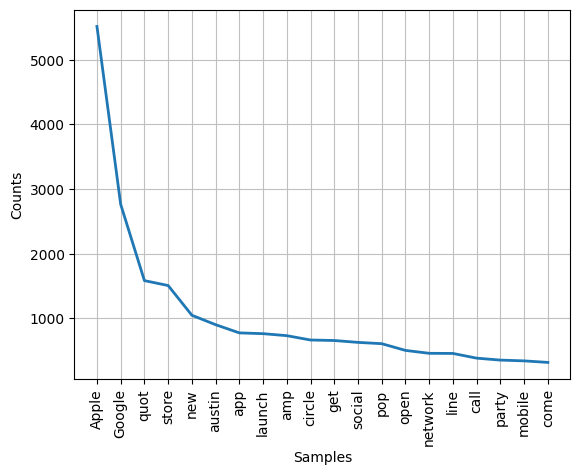

In [37]:

#Plot the 10 most common words
freq_dist.plot(20)
plt.show();

### <a id='toc6_1_4_'></a>[Bigram Frequency](#toc0_)
- Grouping words that occur the most frequently gives us better insight into meaningful combinations of words, such as buzz around talking about Apple stores in Austin ('store', 'Austin'), ('open', 'pop')

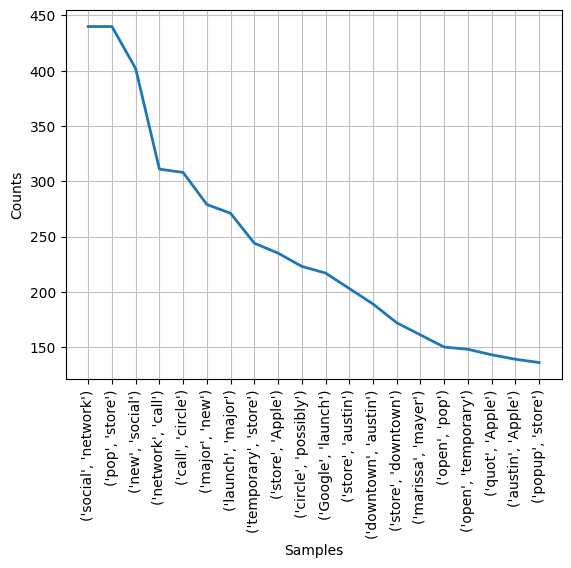

<Axes: xlabel='Samples', ylabel='Counts'>

In [38]:
bigrams = nltk.bigrams(all_words)
tokenized_bigrams = nltk.FreqDist(bigrams)
tokenized_bigrams.most_common(20)
tokenized_bigrams.plot(20)

### <a id='toc6_1_5_'></a>[Trigram Frequency](#toc0_)
- Using trigrams to visualize word frequency yields even more interesting results
- Apple Store insights:
  - We can confirm that the particular Apple store getting the most attention appears to be in downtown Austin ('store', 'downtown', 'austin').
  - This store might have been temporary, AKA a "pop-up":
    - ('temporary', 'store', 'downtown')
    - ('pop', 'store', 'Apple')
    - ('pop', 'store', 'downtown')
  - A quick internet search of "Apple pop-up store 2013 SXSW Austin Texas" only uncovered articles about such a store in 2011, so the sentiment about the pop-up may have been speculative (will the pop-up return this year?).
- App/Product Insights:
  - The two specific apps mentioned most frequently appear to be UberSocial and UberGuide:
    - UberSocial:
      - Trigram: ('new', 'ubersocial', 'app')
      - There appears to be buzz around UberSocial app, a third-party Twitter client app.
      - Because UberSocial launched in 2010, we may be curious why the word "new" is closely associated with it.
    - UberGuide:
      - Trigram: ('store', 'include' 'uberguide')
      - Now we can see why there is buzz around UberSocial in 2013!
      - UberGuide was an SXSW guide available via the UberSocial app in 2013.

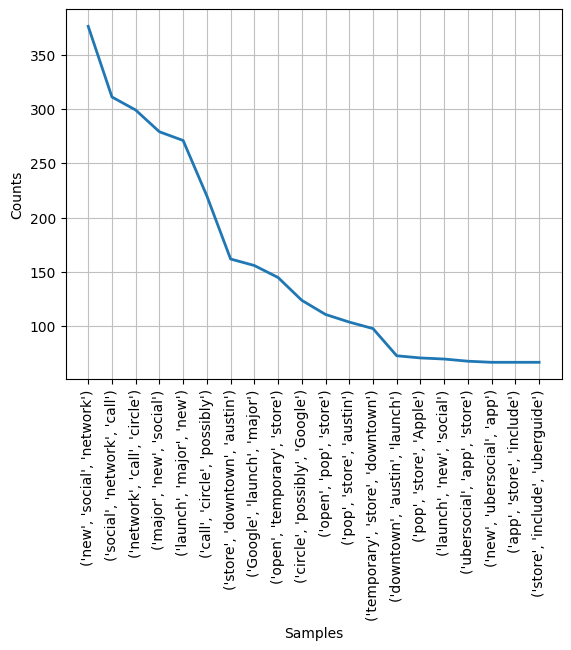

<Axes: xlabel='Samples', ylabel='Counts'>

In [39]:
trigrams = nltk.trigrams(all_words)
tokenized_trigrams = nltk.FreqDist(trigrams)
tokenized_trigrams.most_common(20)
tokenized_trigrams.plot(20)

### <a id='toc6_1_6_'></a>[Use CountVectorizer() to plot Number of Words against Word Frequency](#toc0_)
- This helps us observe that most words in our corpus are infrequent.

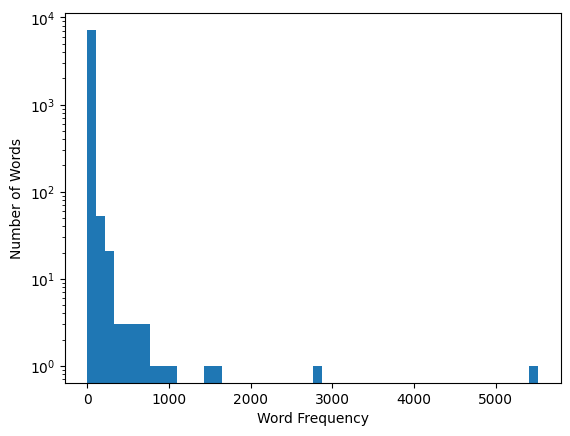

In [40]:
# Vectorize the text
vectorizer = CountVectorizer()
corpse = ()
X = vectorizer.fit_transform(data['text_with_product'])

# Sum the word frequencies
word_freq = X.sum(axis=0)

# Convert to a numpy array and flatten
word_freq = word_freq.A1

# Plot the distribution
plt.hist(word_freq, bins=50, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show();

### <a id='toc6_1_7_'></a>[Visualize Frequency with Word Cloud:](#toc0_)
- The word cloud is a useful visual tool especially for stakeholders, because this form of visualization is extremely engaging and intuitive.
- We instantly observe that Apple is mentioned more than Google in our dataset, that people are commenting on the downtown Apple store in Austin, and the long line out the door.

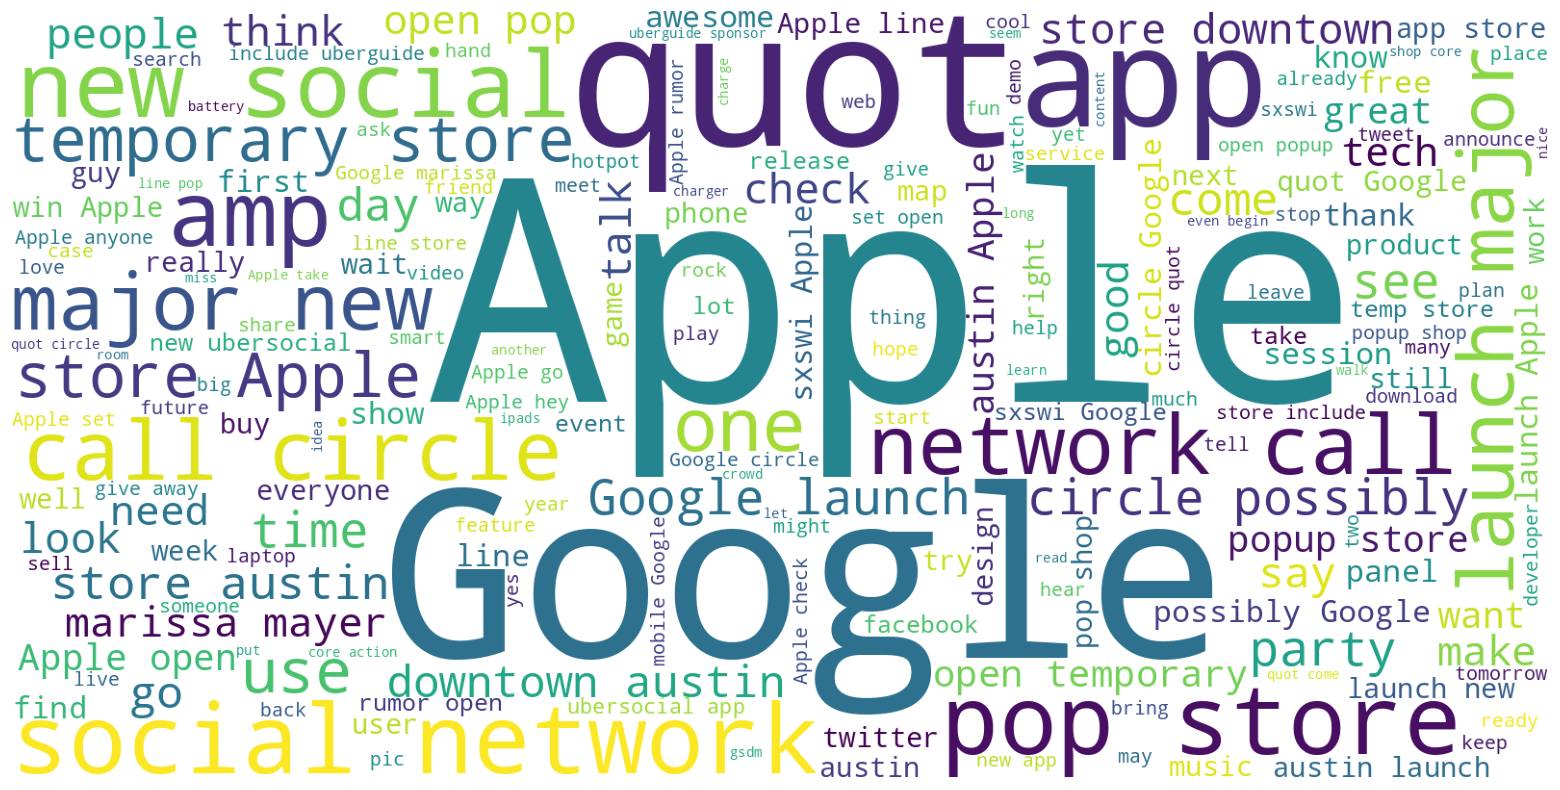

<Figure size 640x480 with 0 Axes>

In [41]:
#Convert word list to a single string
words_string = " ".join(all_words)

#generating the wordcloud
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(words_string)

#plot the wordcloud
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show();

plt.savefig("cloudword.png")

# <a id='toc7_'></a>[Train test split and evaluation metrics](#toc0_)
### <a id='toc7_1_1_'></a>[Define predictor and target variables:](#toc0_)
- Here, we created a three-way split, the purpose of which is to have training data and two testing sets, where the second testing set is for validation.

#### Train Split:

In [42]:
# Assign the concatenated text to X
X = data['text_with_product']

# Assign the target labels to y
y = data['sentiment']

#### Test Split:

In [43]:
X_train_in, X_test, y_train_in, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

#### Validation Split:

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_train_in,
                                                    y_train_in,
                                                    random_state=42,
                                                    test_size=0.2)

# Evaluation Metrics Class
- Here, we defined a class that will record accuracy, recall, precision, F1-Score, and log loss for our train, test, and validation data.
- It tests using cross-validation using `k=5` folds, using accuracy as the scoring method.
- The methods for this class are:
- `print_scores`
  - Returns accuracy, recall, precision, F1-Score, and log loss for model
- `cross_validation`
  - Print validation accuracy score using cross_validate
- `plot_roc_curve_ovr`
  - Plots the graph of a classification model's performance across categorization levels
- `plot_confusion_matrix`
  - Visualization of accuracy via true/false negatives/positives
- `record_results`
  - Records all scores in Dataframe

In [45]:
class EvaluationMetrics:
    #model_df =[]
    model_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Train Recall', 'Train Precision', 'Train F1-Score',
                                              'Train Log Loss','Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1-Score',
                                              'Test Log Loss', 'Validation Accuracy', 'Validation Recall', 'Validation Precision',
                                              'Validation F1-Score'])

    def __init__(self, pipe, X_train, X_test, y_train, y_test, X_val, y_val):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        y_train_pred_proba = self.pipe.predict_proba(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted'),
                              'log_loss': log_loss(self.y_train, y_train_pred_proba)}

        # Test set predictions
        y_test_pred = self.pipe.predict(self.X_test)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        test_results_dict = {'accuracy': accuracy_score(self.y_test, y_test_pred),
                             'recall': recall_score(self.y_test, y_test_pred, average='weighted'),
                             'precision': precision_score(self.y_test, y_test_pred, average='weighted'),
                             'f1_score': f1_score(self.y_test, y_test_pred, average='weighted'),
                             'log_loss': log_loss(self.y_test, y_test_pred_proba)}

        # Validation set predictions
        y_val_pred = self.pipe.predict(self.X_val)
        y_val_pred_proba = self.pipe.predict_proba(self.X_val)
        val_results_dict = {'accuracy': accuracy_score(self.y_val, y_val_pred),
                            'recall': recall_score(self.y_val, y_val_pred, average='weighted'),
                            'precision': precision_score(self.y_val, y_val_pred, average='weighted'),
                            'f1_score': f1_score(self.y_val, y_val_pred, average='weighted'),
                            'log_loss': log_loss(self.y_val, y_val_pred_proba)}

        return train_results_dict, test_results_dict, val_results_dict

    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)

    # Plots ROC curve for all classes
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()

    # Plots confusion matrix
    def plot_confusion_matrix(self, y_train, y_train_pred):
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

    def record_results(self, model_name, train_results, test_results, val_results):
        new_row = {'Model': model_name,
               'Train Accuracy': train_results['accuracy'],
               'Train Recall': train_results['recall'],
               'Train Precision': train_results['precision'],
               'Train F1-Score': train_results['f1_score'],
               'Train Log Loss': train_results['log_loss'],
               'Test Accuracy': test_results['accuracy'],
               'Test Recall': test_results['recall'],
               'Test Precision': test_results['precision'],
               'Test F1-Score': test_results['f1_score'],
               'Test Log Loss': test_results['log_loss'],
               'Validation Accuracy': val_results['accuracy'],
               'Validation Recall': val_results['recall'],
               'Validation Precision': val_results['precision'],
               'Validation F1-Score': val_results['f1_score'],
               'Validation Log Loss': val_results['log_loss']}
        new_row_df= pd.DataFrame(new_row, index=[0])
        self.model_df = pd.concat([self.model_df, new_row_df],ignore_index=True)

        # self.model_df.loc[len(self.model_df)] = new_row
        # results = pd.concat([self.model_df, results, results_1], ignore_index =True)

# <a id='toc8_'></a>[DummyModel](#toc0_)
- Our first baseline model gives us an idea of how accurate we would be if we simply predicted the majority class for all rows.
- The majority class is neutral at 58% of data
- To justify any subsequent models as viable options, we must improve on the baseline model accuracy.

In [108]:
# Most sentiments are neutral, followed by positive.
# 1 = Neutral
# 2 = Positive
# 0 = Negative
data['sentiment'].value_counts(normalize=True)

1    0.577587
2    0.353822
0    0.068591
Name: sentiment, dtype: float64

In [46]:
dummy = Pipeline([
    ('vect', CountVectorizer(min_df=0.05, max_df=0.95)),
    ('dummy', DummyClassifier(random_state=42, ))
])

# Fit the pipeline to the training data
dummy.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('dummy', DummyClassifier(random_state=42))])

In [47]:
dummy_metrics = EvaluationMetrics(dummy, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = dummy_metrics.print_scores()
dummy_metrics.record_results('DummyModel', train_results, test_results, val_results)

### <a id='toc8_1_1_'></a>[Baseline Model Results:](#toc0_)

In [48]:
dummy_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.43376,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097


### Baseline Model Discussion:
- This model predicts all tweets as neutral
- We need to improve on the 58% accuracy in order to justify saying we've improved the skill of any subsequent model.

# <a id='toc9_'></a>[Logistic regression](#toc0_)
#### <a id='toc9_1_1_1_'></a>[Logistic Regression using CountVectorizer](#toc0_)
- Our next model uses simple logistice regression to classify sentiment
- We use CountVectorizer() to create a sparse representation of our tweet text.
- The output of CountVectorizer() is data where each row is a tweet, each column is a word/token in the corpus, and each cell contains the frequency (count) of each word that occurs in the entire corpus.


In [49]:
lg_cv = Pipeline([
    ('vect', CountVectorizer(min_df=0.05, max_df=0.75,)),
    ('logreg', LogisticRegression(random_state=42, ))
])

# Fit the pipeline to the training data
lg_cv.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.75, min_df=0.05)),
                ('logreg', LogisticRegression(random_state=42))])

In [50]:
lg_cv_metrics = EvaluationMetrics(lg_cv, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_cv_metrics.print_scores()
lg_cv_metrics.record_results('Logreg_countV', train_results, test_results, val_results)

In [51]:
lg_cv_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.84424,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683


#### <a id='toc9_1_1_2_'></a>[Compare Models](#toc0_)


In [52]:
model_list = [dummy_metrics.model_df, lg_cv_metrics.model_df]

In [53]:
concat_results = pd.concat(model_list,ignore_index=True)

In [54]:
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683


### Logistic Regression Discussion:
- Logistic Regression and CountVectorizer() improved accuracy slightly over the baseline model:
- Train accuracy is .577(baseline) vs. .583 (logreg)
- Test accuracy is .587(baseline) vs. .597 (logreg)

### <a id='toc9_1_2_'></a>[Logistic regression with Tf-idf vectorizer](#toc0_)
>- Model preformed better than our baseline as well as countvector vectorizer on training set
>- But not so well on test and validation, this could be a product of overfitting and the initial class imbalance observed
>- Logistic regression models are prone to overfit when models too complex, or with insuficient regulirization
>- We'll apply smote, some hyperparameters to see if that'll improve performance

In [55]:
lg_tfidf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 1))),
    ('logreg', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training data
lg_tfidf.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('logreg', LogisticRegression(random_state=42))])

In [56]:
lg_tfidf_metrics = EvaluationMetrics(lg_tfidf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_tfidf_metrics.print_scores()
lg_tfidf_metrics.record_results('Logreg_TF-IDF', train_results, test_results, val_results)

In [57]:
lg_tfidf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.63475,0.72909,0.645283,0.645283,0.645948,0.615897,0.759868


In [58]:
# Compare All Models So Far:
model_list.append(lg_tfidf_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868


### Logistic Regression with TF-IDF for sparse representation Discussion:
- This model is significantly overfit (train accuracy = .799, test accuracy = .663)
- Now we'll proceed to apply SMOTE in order to address class imbalance in target variable

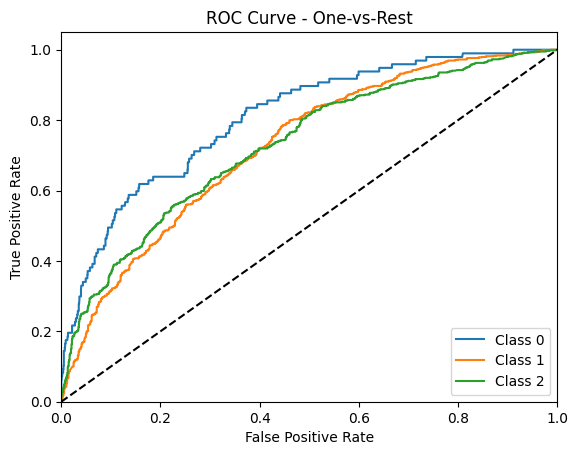

In [59]:
lg_tfidf_metrics.plot_roc_curve_ovr()

### <a id='toc9_1_3_'></a>[Smote Logistic Regression with TF_IDF](#toc0_)
>- Using SMOTE and balanced class weight among limiting vector features adresses our overfitting
>- Model training, validation and test result in similar accuracy rates
>- logloss is high and performance has decreased from previous overfit lr model

In [60]:
from imblearn.over_sampling import SMOTE
# Create an instance of SMOTE
smote = SMOTE()

# Define the pipeline
lg_sm = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 1),min_df=0.01, max_df=0.75,max_features=1000),
    smote,
    LogisticRegression(random_state=42,multi_class='multinomial', C=0.01, penalty='l2', class_weight='balanced', max_iter=125)
)

# Fit the pipeline to the training data
lg_sm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01)),
                ('smote', SMOTE()),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=125, multi_class='multinomial',
                                    random_state=42))])

In [61]:
lg_sm_metrics = EvaluationMetrics(lg_sm, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_sm_metrics.print_scores()
lg_sm_metrics.record_results('Logreg_TF-IDF_Smote', train_results, test_results, val_results)

In [62]:
lg_sm_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166


In [63]:
# Compare All Models So Far:
model_list.append(lg_sm_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166


### Logistic Regression, TF-IDF with SMOTE Discussion:
- We've addressed class imbalance, but unfortunately our accuracy is now below the baseline model.
- We'll now proceed to methods for reducing noise so that our model can pick up on more signal.

## <a id='toc9_2_'></a>[PCA](#toc0_)
### <a id='toc9_2_1_'></a>[TruncatedSVD](#toc0_)
#### <a id='toc9_2_1_1_'></a>[Our data could be having a lot of noise and one method to deal with it is using dimension reduction](#toc0_)
>- Using TruncatedSVD our result was still not that better, the parameters applied are best gridsearched prams
>- Model's performance is balanced but accuracy is low

In [64]:
lg_sm_pca = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000),
    TruncatedSVD(n_components=125),  # Specify the desired number of components
    smote,
    LogisticRegression(random_state=42, multi_class='multinomial', C=0.01, penalty='l2', class_weight='balanced', solver='saga')
)
lg_sm_pca.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('truncatedsvd', TruncatedSVD(n_components=125)),
                ('smote', SMOTE()),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    multi_class='multinomial', random_state=42,
                                    solver='saga'))])

In [65]:
lg_sm_pca_metrics = EvaluationMetrics(lg_sm_pca, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_sm_pca_metrics.print_scores()
lg_sm_pca_metrics.record_results('Logreg_TF-IDF_TSVD', train_results, test_results, val_results)

In [66]:
lg_sm_pca_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.5361,1.03778,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956


In [67]:
# Compare All Models So Far:
model_list.append(lg_sm_pca_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956


### PCA Discussion:


### <a id='toc9_2_2_'></a>[Negative Matrix Factorization](#toc0_)
>- NMF has better model performance on accuracy from other pca methods

In [68]:
lg_nmf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000)),
    ('nmf', NMF(n_components=125)),  # Specify the desired number of component
    ('logreg', LogisticRegression(random_state=42, multi_class='multinomial', penalty='l2'))
])
lg_nmf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('nmf', NMF(n_components=125)),
                ('logreg',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=42))])

In [69]:
lg_nmf_metrics = EvaluationMetrics(lg_nmf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_nmf_metrics.print_scores()
lg_nmf_metrics.record_results('Logreg_TF-IDF_NMF', train_results, test_results, val_results)

In [70]:
lg_nmf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901


In [71]:
# Compare All Models So Far:
model_list.append(lg_nmf_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901


In [72]:
# Smote with NMF

# <a id='toc10_'></a>[MultinomialNB Model](#toc0_)
>- Model performed better than our logistic regression trials above but it is performing much better on training set than test set
>- We are using best params from previously grid searched prams

In [73]:
mnbpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features= 500)),
    ('mnb', MultinomialNB(alpha=2.0, fit_prior=True))
])

# Fit the pipeline to the training data
mnbpipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.75, max_features=500, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('mnb', MultinomialNB(alpha=2.0))])

In [74]:
mnbpipe_metrics = EvaluationMetrics(mnbpipe, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = mnbpipe_metrics.print_scores()
mnbpipe_metrics.record_results('MultinomialNB_TF-IDF_', train_results, test_results, val_results)

In [75]:
mnbpipe_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588


In [76]:
# Compare All Models So Far:
model_list.append(mnbpipe_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901
6,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588


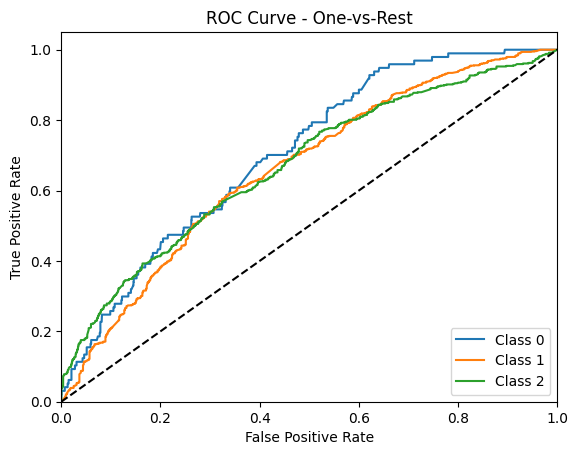

In [77]:
mnbpipe_metrics.plot_roc_curve_ovr()

### <a id='toc10_1_1_'></a>[Negative Matrix Factorization](#toc0_)
>- Using dimesion reduction for better model performance

In [78]:
mnb_nmf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.95, max_features=100)),
    ('nmf', NMF(n_components=100)),  # Specify the desired number of component
    ('mnb', MultinomialNB(alpha=2.0, fit_prior=True))
])
mnb_nmf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=100, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('nmf', NMF(n_components=100)),
                ('mnb', MultinomialNB(alpha=2.0))])

In [79]:
mnb_nmf_metrics = EvaluationMetrics(mnb_nmf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = mnb_nmf_metrics.print_scores()
mnb_nmf_metrics.record_results('MultinomialNB_TF-IDF_NMF', train_results, test_results, val_results)

In [80]:
mnb_nmf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.59143,0.59143,0.70063,0.44461,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524


In [81]:
# Compare All Models So Far:
model_list.append(mnb_nmf_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901
6,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588
7,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.591430,0.591430,0.700630,0.444610,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524


# <a id='toc11_'></a>[Random Forest Model](#toc0_)
>- with gridsearched best hyperperameters

In [82]:
rfpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, analyzer='word', max_features=1000)),
    ('rf', RandomForestClassifier(n_estimators=300,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False ))
])

# Fit the pipeline to the training data
rfpipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=20, n_estimators=300))])

In [83]:
rfpipe_metrics = EvaluationMetrics(rfpipe, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = rfpipe_metrics.print_scores()
rfpipe_metrics.record_results('RandomForest_TF-IDF', train_results, test_results, val_results)

In [84]:
rfpipe_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,RandomForest_TF-IDF,0.746556,0.746556,0.807409,0.716607,0.605416,0.640917,0.640917,0.653318,0.583251,0.78407,0.617358,0.617358,0.598776,0.556519,0.819526


In [85]:
# Compare All Models So Far:
model_list.append(rfpipe_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901
6,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588
7,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.591430,0.591430,0.700630,0.444610,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524
8,RandomForest_TF-IDF,0.746556,0.746556,0.807409,0.716607,0.605416,0.640917,0.640917,0.653318,0.583251,0.784070,0.617358,0.617358,0.598776,0.556519,0.819526


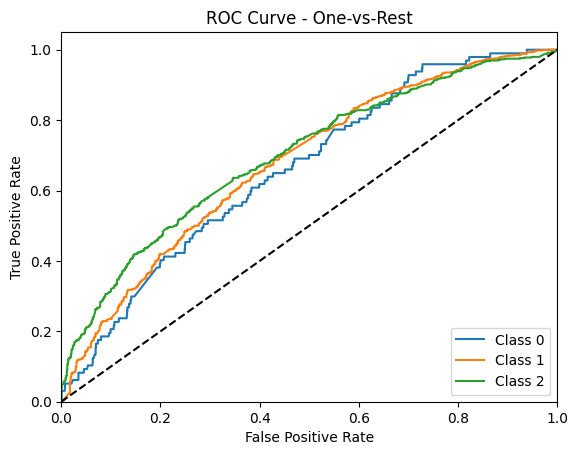

In [86]:
rfpipe_metrics.plot_roc_curve_ovr()

### <a id='toc11_1_1_'></a>[Negative Matrix Factorization](#toc0_)

In [87]:
rf_nmf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.95, max_features=100)),
    ('nmf', NMF(n_components=70)),  # Specify the desired number of component
    ('rf', RandomForestClassifier(n_estimators=300,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False ))
])
rf_nmf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=100, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('nmf', NMF(n_components=70)),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=20, n_estimators=300))])

In [88]:
rf_nmf_metrics = EvaluationMetrics(rf_nmf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = rf_nmf_metrics.print_scores()
rf_nmf_metrics.record_results('RandomForest_TF-IDF_NMF', train_results, test_results, val_results)

In [89]:
rf_nmf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,RandomForest_TF-IDF_NMF,0.779581,0.779581,0.817745,0.76064,0.53617,0.645745,0.645745,0.628949,0.598247,0.804274,0.612075,0.612075,0.583309,0.563291,0.84589


In [90]:
# Compare All Models So Far:
model_list.append(rf_nmf_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901
6,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588
7,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.591430,0.591430,0.700630,0.444610,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524
8,RandomForest_TF-IDF,0.746556,0.746556,0.807409,0.716607,0.605416,0.640917,0.640917,0.653318,0.583251,0.784070,0.617358,0.617358,0.598776,0.556519,0.819526
9,RandomForest_TF-IDF_NMF,0.779581,0.779581,0.817745,0.760640,0.536170,0.645745,0.645745,0.628949,0.598247,0.804274,0.612075,0.612075,0.583309,0.563291,0.845890


#### <a id='toc11_1_1_1_'></a>[TruncatedSVD](#toc0_)

In [91]:
rf_svd = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000),
    TruncatedSVD(n_components=125),  # Specify the desired number of components
    smote,
    RandomForestClassifier(n_estimators=200,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False)
)
rf_svd.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('truncatedsvd', TruncatedSVD(n_components=125)),
                ('smote', SMOTE()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=20, n_estimators=200))])

In [92]:
rf_svd_metrics = EvaluationMetrics(rf_svd, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = rf_svd_metrics.print_scores()
rf_svd_metrics.record_results('RandomForest_TF-IDF_SVD', train_results, test_results, val_results)

In [93]:
rf_svd_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,RandomForest_TF-IDF_SVD,0.862616,0.862616,0.878758,0.867033,0.282888,0.562462,0.562462,0.584355,0.572056,1.017797,0.560755,0.560755,0.573851,0.56605,1.261912


In [94]:
# Compare All Models So Far:
model_list.append(rf_svd_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901
6,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588
7,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.591430,0.591430,0.700630,0.444610,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524
8,RandomForest_TF-IDF,0.746556,0.746556,0.807409,0.716607,0.605416,0.640917,0.640917,0.653318,0.583251,0.784070,0.617358,0.617358,0.598776,0.556519,0.819526
9,RandomForest_TF-IDF_NMF,0.779581,0.779581,0.817745,0.760640,0.536170,0.645745,0.645745,0.628949,0.598247,0.804274,0.612075,0.612075,0.583309,0.563291,0.845890


# <a id='toc12_'></a>[XGBoosting](#toc0_)
>- With smote, TF-IDF and NMF dimension reduction
>- XGBoosting perfomed better with countvectorizer than TF-IDF

In [95]:
# Create an instance of TfidfVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))
sm = SMOTE()

# Define the individual classifiers
lg = LogisticRegression(random_state=42,multi_class='multinomial', C=0.01, penalty='l2', class_weight='balanced', max_iter=1000)
mnb = MultinomialNB(alpha=2.0, fit_prior=True)
nmf = NMF(n_components=100)

rf = RandomForestClassifier(n_estimators=200,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False)
xgb = XGBClassifier(
    estimators=[
        ('lg', lg),
        ('mnb', mnb),
        ('rf', rf)
    ],
    voting='soft',max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    verbosity=1,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=42,
)

xgb_pipeline = make_pipeline(vectorizer,sm, nmf,xgb)

# xgb_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()), ('nmf', NMF(n_components=100)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               estimators=[('lg',
                                            LogisticRegre...
                               eval_metric=None, feature_types=None, gamma=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100, n_jobs=1,
                               nthread=None, ...))])

In [96]:
xgb_pipeline_metrics = EvaluationMetrics(xgb_pipeline, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = xgb_pipeline_metrics.print_scores()
xgb_pipeline_metrics.record_results('XGBoosting_CountV_SVD', train_results, test_results, val_results)

In [97]:
xgb_pipeline_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,XGBoosting_CountV_SVD,0.686356,0.686356,0.6776,0.67512,0.768112,0.633072,0.633072,0.61301,0.616149,0.831056,0.58566,0.58566,0.562075,0.567778,0.867859


In [98]:
# Compare All Models So Far:
model_list.append(xgb_pipeline_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901
6,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588
7,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.591430,0.591430,0.700630,0.444610,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524
8,RandomForest_TF-IDF,0.746556,0.746556,0.807409,0.716607,0.605416,0.640917,0.640917,0.653318,0.583251,0.784070,0.617358,0.617358,0.598776,0.556519,0.819526
9,RandomForest_TF-IDF_NMF,0.779581,0.779581,0.817745,0.760640,0.536170,0.645745,0.645745,0.628949,0.598247,0.804274,0.612075,0.612075,0.583309,0.563291,0.845890


In [99]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
sm = SMOTE()

# Define the individual classifiers
lg = LogisticRegression(random_state=42,multi_class='multinomial', C=0.01, penalty='l2', class_weight='balanced', max_iter=1000)
mnb = MultinomialNB(alpha=2.0, fit_prior=True)
nmf = NMF(n_components=100)

rf = RandomForestClassifier(n_estimators=200,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False)
xgb_tfidf = XGBClassifier(
    estimators=[
        ('lg', lg),
        ('mnb', mnb),
        ('rf', rf)
    ],
    voting='soft',max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    verbosity=1,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=42,
)

xgb_pipe_tfidf = make_pipeline(vectorizer,sm, nmf,xgb_tfidf)

# xgb_pipeline.fit(X_train, y_train)
xgb_pipe_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()), ('nmf', NMF(n_components=100)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               estimators=[('lg',
                                            LogisticRegre...
                               eval_metric=None, feature_types=None, gamma=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100, n_jobs=1,
                               nthread=None, ...))])

In [100]:
xgb_tfidf_metrics = EvaluationMetrics(xgb_pipe_tfidf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = xgb_tfidf_metrics.print_scores()
xgb_tfidf_metrics.record_results('XGBoosting_TF-IDF_SVD', train_results, test_results, val_results)

In [101]:
xgb_tfidf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,XGBoosting_TF-IDF_SVD,0.646915,0.646915,0.687347,0.657965,0.799205,0.549185,0.549185,0.583351,0.562526,0.899515,0.550943,0.550943,0.568758,0.558312,0.912738


In [102]:
# Compare All Models So Far:
model_list.append(xgb_tfidf_metrics.model_df)
concat_results = pd.concat(model_list,ignore_index=True)
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901
6,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588
7,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.591430,0.591430,0.700630,0.444610,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524
8,RandomForest_TF-IDF,0.746556,0.746556,0.807409,0.716607,0.605416,0.640917,0.640917,0.653318,0.583251,0.784070,0.617358,0.617358,0.598776,0.556519,0.819526
9,RandomForest_TF-IDF_NMF,0.779581,0.779581,0.817745,0.760640,0.536170,0.645745,0.645745,0.628949,0.598247,0.804274,0.612075,0.612075,0.583309,0.563291,0.845890


In [104]:
from sklearn.multiclass import OneVsRestClassifier

# Vectorize the text data using TF-IDF
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000)
X_train_vectorized = vectorizer.fit_transform(X_train_em)
X_test_vectorized = vectorizer.transform(X_test_em)

#dimensionality reduction
lda = LatentDirichletAllocation(n_components=100)
X_train_lda = lda.fit_transform(X_train_vectorized)
X_test_lda = lda.transform(X_test_vectorized)

# Train a logistic regression model using the topic distributions as features
logreg = LogisticRegression()
model = OneVsRestClassifier(logreg)
model.fit(X_train_lda, y_train_em)
y_pred = model.predict(X_test_lda)

In [105]:
y_pred = model.predict(X_test_lda)
print(classification_report(y_test_em, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.62      0.89      0.73       972
           2       0.57      0.26      0.36       588

    accuracy                           0.61      1657
   macro avg       0.40      0.38      0.36      1657
weighted avg       0.57      0.61      0.56      1657



In [106]:
concat_results

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.433760,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097
1,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.844240,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683
2,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.634750,0.729090,0.645283,0.645283,0.645948,0.615897,0.759868
3,Logreg_TF-IDF_Smote,0.502359,0.502359,0.613464,0.534978,1.034671,0.468316,0.468316,0.590713,0.507221,1.046878,0.459623,0.459623,0.570742,0.491954,1.051166
4,Logreg_TF-IDF_TSVD,0.503491,0.503491,0.616585,0.536100,1.037780,0.467109,0.467109,0.591286,0.505158,1.049082,0.464151,0.464151,0.577657,0.497017,1.052956
5,Logreg_TF-IDF_NMF,0.600679,0.600679,0.570484,0.497234,0.832241,0.602897,0.602897,0.573399,0.496514,0.821347,0.581887,0.581887,0.534635,0.480061,0.850901
6,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588
7,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.591430,0.591430,0.700630,0.444610,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524
8,RandomForest_TF-IDF,0.746556,0.746556,0.807409,0.716607,0.605416,0.640917,0.640917,0.653318,0.583251,0.784070,0.617358,0.617358,0.598776,0.556519,0.819526
9,RandomForest_TF-IDF_NMF,0.779581,0.779581,0.817745,0.760640,0.536170,0.645745,0.645745,0.628949,0.598247,0.804274,0.612075,0.612075,0.583309,0.563291,0.845890


# Discussion of Best Models:
### Logreg_TF-IDF
- High performance across all metrics in training, test, and validation datasets.
- Consistency between training and test/validation performance, indicating good generalization.
- F1-Score, which considers both precision and recall, is also high.
### MultinomialNBTF-IDF
- Good performance across test and validation datasets.
- Slightly higher log loss compared to some other models, but still competitive.
- Consistent performance across different metrics.
### RandomForest_TF-IDF
- High performance in training, and good performance in test and validation datasets.
- Consistency in metrics across different datasets.
- Slightly higher log loss in validation dataset.
### RandomForest_TF-IDF_NMF
- Good performance in training, test, and validation datasets.
- Consistency across different metrics.
- Slightly higher log loss in test and validation datasets compared to some other models.
### Logreg_TF-IDF_NMF
- Good performance across all datasets.
- Consistency in metrics across different datasets.
- Slightly lower performance in F1-Score compared to the models ranked above.
# Models with Concerns:
- Logreg_TF-IDF_Smote, Logreg_TF-IDF_TSVD, and RandomForest_TF-IDF_SVD have significantly lower performance in the test and validation datasets compared to the training dataset, indicating potential overfitting.
- DummyModel, Logreg_countV, and MultinomialNB_TF-IDF_NMF have lower performance metrics compared to the top models.

# Conclusion:
Our model was unbalanced with 7% negative, 58% positive and 35% who had no emotion or couldn’t tell their feelings from the tweet. We tried modeling with Countvector and TF-IDF, we tried to balance our data with smote and embedding techniques to reduce dimension, such as negative matrix factorization, Turnicated SVD and LatentDirichletAllocation embedding techniques unfortunately our data was not enough and dimension reduction couldn’t help our models performance. Although we did get pretty balanced across all metrics with logistic regression and LatentDirichletAllocation, the best performer given the amount of data was Logistic regression with TF-IDF. Model performance across all models had a weakness of predicting negative emotion with certain data splits having no instance of tweet corpus with negative emotion.

# Appendix: Word Embedding using Keras:
- Goal: Learn a word embedding via a dense vector representation, whilst fitting a neural network
- Why? - Can work better than sparse representations (Bag of Words Model)
  - A sparse representation is something like the output of TF-IDF -- because the columns represent the entire vocabulary, there are a large number of columns, and most values are 0 where the document (row) does not contain that token.
- Rather than a sparse representation, embedding uses dense vectors to represent where a given word is positioned within text in relation to the other words.

In [103]:
# Preprocess your text data and split into train and test sets
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import class_weight

# Vectorize the text data using TF-IDF
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000)
X_train_vectorized = vectorizer.fit_transform(X_train_em)
X_test_vectorized = vectorizer.transform(X_test_em)

# Apply LDA for dimensionality reduction
lda = LatentDirichletAllocation(n_components=100)
X_train_lda = lda.fit_transform(X_train_vectorized)
X_test_lda = lda.transform(X_test_vectorized)

# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=X_train_lda.shape[1], output_dim=100, input_length=X_train_lda.shape[1]))
model.add(LSTM(128))
model.add(Dense(12, activation='sigmoid'))


class_weight = class_weight.compute_sample_weight('balanced',y_train_em)
# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.fit(X_train_lda, y_train_em, validation_data=(X_test_lda, y_test),epochs=5, batch_size=32)


Epoch 1/5
207/207 [==============================] - 45s 206ms/step - loss: 0.9457 - accuracy: 0.5694 - val_loss: 0.8639 - val_accuracy: 0.5866
Epoch 2/5
207/207 [==============================] - 58s 281ms/step - loss: 0.8851 - accuracy: 0.5643 - val_loss: 0.8477 - val_accuracy: 0.5866
Epoch 3/5
207/207 [==============================] - 52s 253ms/step - loss: 0.8796 - accuracy: 0.5714 - val_loss: 0.8552 - val_accuracy: 0.5866
Epoch 4/5
207/207 [==============================] - 66s 320ms/step - loss: 0.8810 - accuracy: 0.5753 - val_loss: 0.8511 - val_accuracy: 0.5866
Epoch 5/5
207/207 [==============================] - 52s 250ms/step - loss: 0.8812 - accuracy: 0.5720 - val_loss: 0.8497 - val_accuracy: 0.5866
